In [1]:
import lightning as L
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader
from lightning import Trainer
from icecream import ic
import matplotlib.pyplot as plt
from IPython.display import clear_output


cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/__init__.py:1240: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


'cuda'

In [2]:
# models definition

class CustomActivation(nn.Module):
    def __init__(self, input_dim, approx_dim=7):
        super().__init__()
        ic(input_dim)
        z = torch.Tensor([1/4]*min(approx_dim, 4)+[0]*(approx_dim-4))
        self.z = z.reshape(1,approx_dim)
        self.psi = z

    def forward(self, x):
        tmp = x @ self.psi.unsqueeze(-1)


        # 1 - exp(-tmp) with a ReLU clamp at 0
        # (since your original code did maximum(0, 1 - exp(-tmp)))
        tmp2 = torch.maximum(
            torch.zeros_like(tmp),
            1 - torch.exp(-tmp)
        )

        # Multiply by z => shape [batch,7] by broadcasting
        # [batch,1] * [7] => [batch, 7]
        out = tmp2 * self.z

        # ic(x.shape, tmp.shape, out.shape)
        return out


class SinglePath(nn.Module):
    def __init__(self, input_dim=7, approx_dim=7):
        super().__init__()
        self.path = nn.Sequential(
            nn.Linear(input_dim, approx_dim, bias=True),
            CustomActivation(input_dim, approx_dim),
            nn.Linear(approx_dim, 1, bias=False)
        )

    def forward(self, x):
        return self.path(x)


class MyModel(L.LightningModule):

    def __init__(self):
        super().__init__()
        self.training_loss = []
        self.validation_loss = []

    def forward(self, x):
        x = x[:, :self.noise_dim]
        return self.model(x)

    def log(self, dest, *args, **kwargs):
        super().log(dest, *args, **kwargs)
        if dest == "train_loss":
            self.training_loss.append(args[0].item())
        elif dest == "val_loss":
            self.validation_loss.append(args[0].item())

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-3, weight_decay=1e-3)


class Standard(MyModel):
    def __init__(self, partition_size, noise_dim):
        super().__init__()
        self.noise_dim = noise_dim
        self.model = nn.Sequential(
            nn.Linear(partition_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
        self.loss_fn = nn.MSELoss()


class MultiPath(MyModel):
    def __init__(self, partition_size, n_paths, noise_dim):
        super().__init__()
        self.paths = []
        self.paths = nn.ModuleList(
            [SinglePath(partition_size, noise_dim) for _ in range(n_paths)]
        )
        self.loss_fn = nn.MSELoss()
        self.noise_dim = noise_dim

    def forward(self,x):
        x = x[:, :self.noise_dim]
        outs = [path(x) for path in self.paths]
        return torch.stack(outs, dim=0).sum(dim=0)

# Standard basis

In [3]:
def train_eval(noise_dim, epochs=30):
    train_x = torch.load(f'data/train_x_{noise_dim}_laguerre.pt').to(torch.float32)
    train_y = torch.load(f'data/train_y_{noise_dim}_laguerre.pt').to(torch.float32)
    test_x  =  torch.load('data/test_x_laguerre.pt').to(torch.float32) #[:10,:]
    test_y  =  torch.load('data/test_y_laguerre.pt').to(torch.float32) #[:10]
    validation_x = test_x[:len(test_x)//2,:]
    validation_y = test_y[:len(test_y)//2]
    test_x = test_x[len(test_x)//2:,:]
    test_y = test_y[len(test_y)//2:]

    generator = torch.Generator(device=device)

    train_dataset = TensorDataset(train_x, train_y)
    validation_dataset = TensorDataset(validation_x, validation_y)
    test_dataset = TensorDataset(test_x, test_y)

    train_loader = DataLoader(train_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)
    validation_loader = DataLoader(validation_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)
    
    path_model = MultiPath(train_x.shape[-1], 10, noise_dim=noise_dim)
    standard_model = Standard(train_x.shape[-1], noise_dim=noise_dim)
    for model in [path_model, standard_model]:
        trainer = Trainer(max_epochs=epochs, accelerator="auto", devices=1)
        trainer.test(model, dataloaders=test_loader)
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
        trainer.test(model, dataloaders=test_loader)
    return [path_model, standard_model]
        


In [4]:
models = []

In [6]:
for noise_dim in range(2, 11):
    clear_output(wait=True)
    print(f"Training models with noise dim {noise_dim}")
    models.append(train_eval(noise_dim, 100))


ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
ic| input_dim: 10
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training models with noise dim 10


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     5.573784828186035     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | paths   | ModuleList | 1.2 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.005724764429032803    │
└───────────────────────────┴───────────────────────────┘

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     7.529232025146484     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 3.5 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0003004399477504194   │
└───────────────────────────┴───────────────────────────┘

In [7]:
len(models)

9

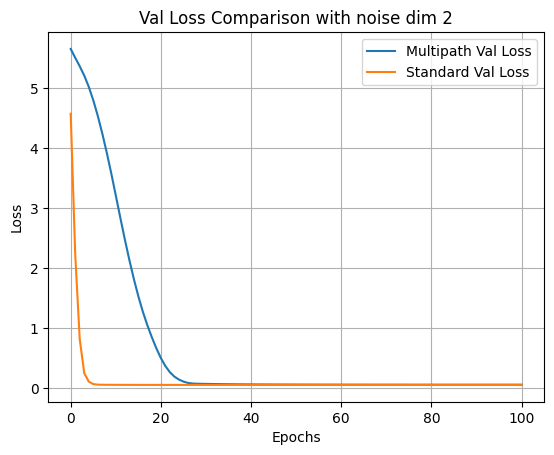

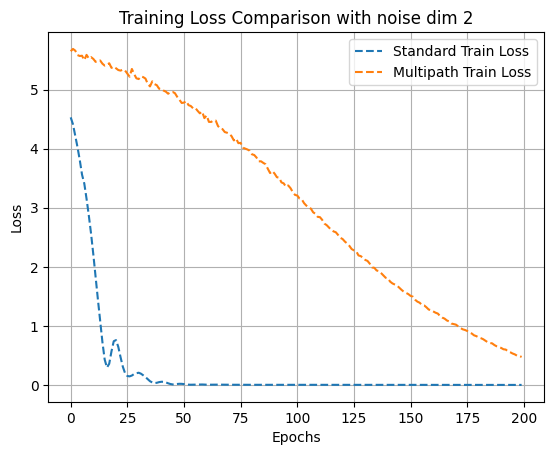

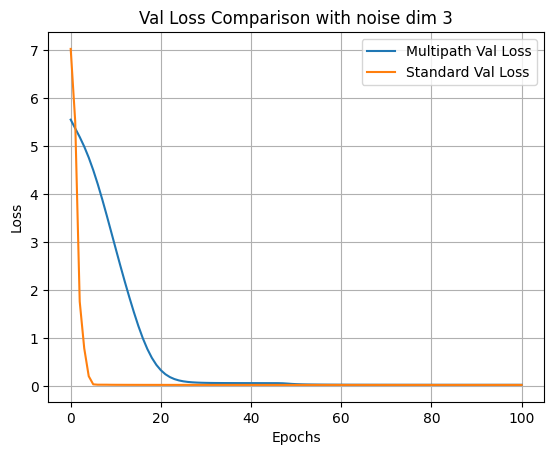

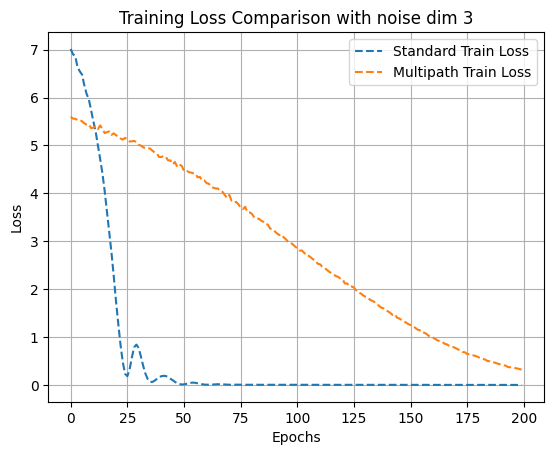

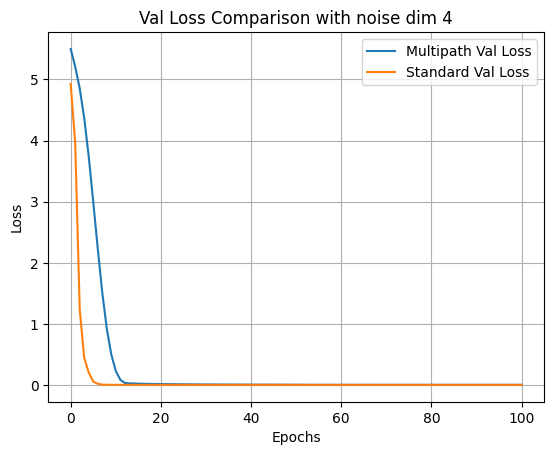

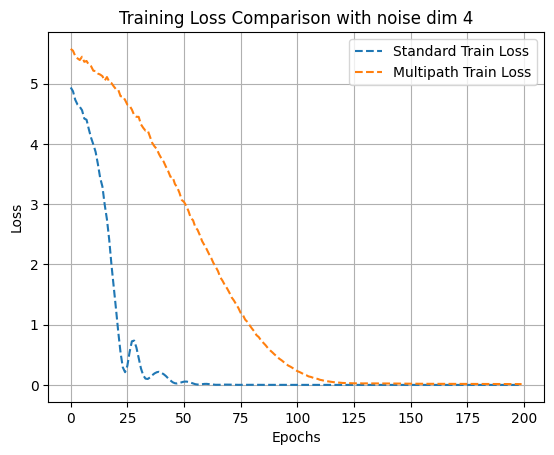

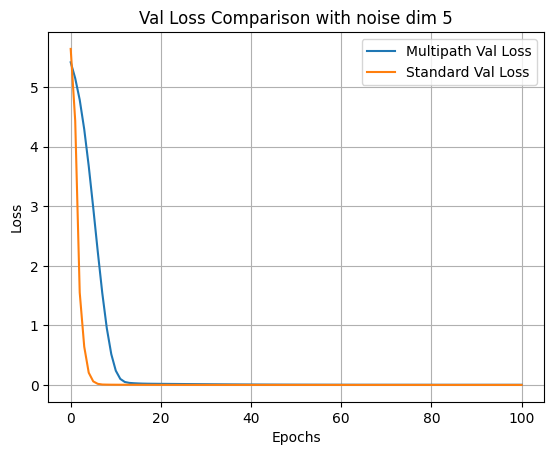

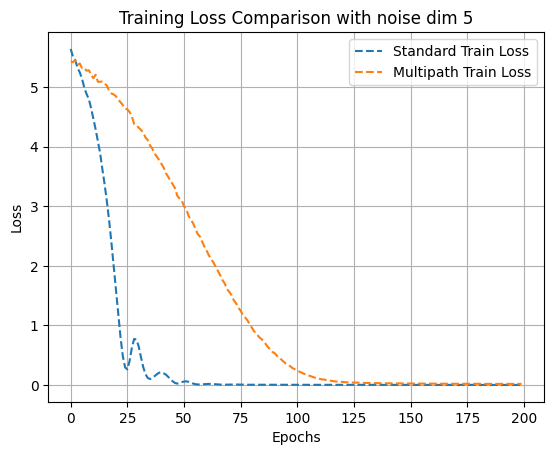

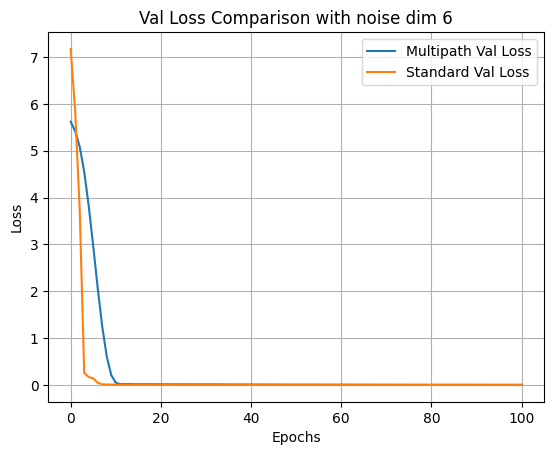

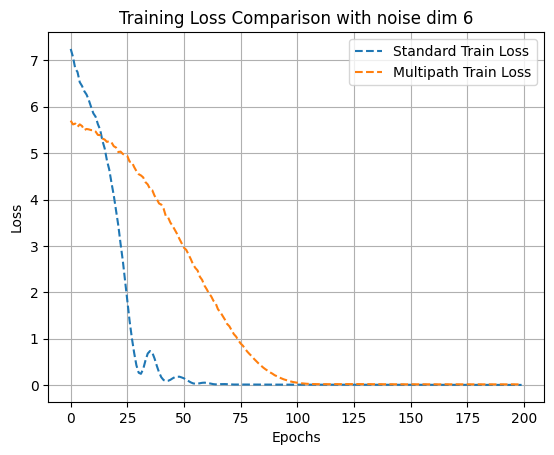

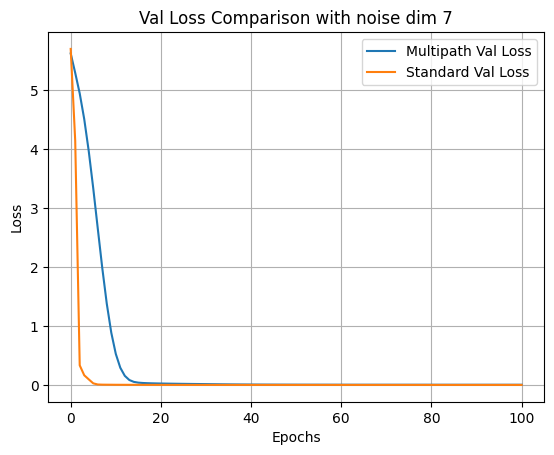

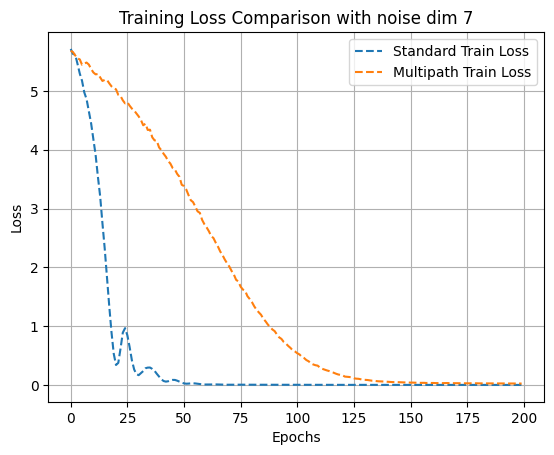

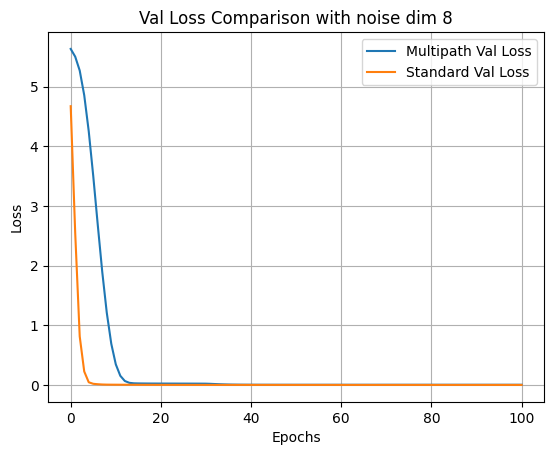

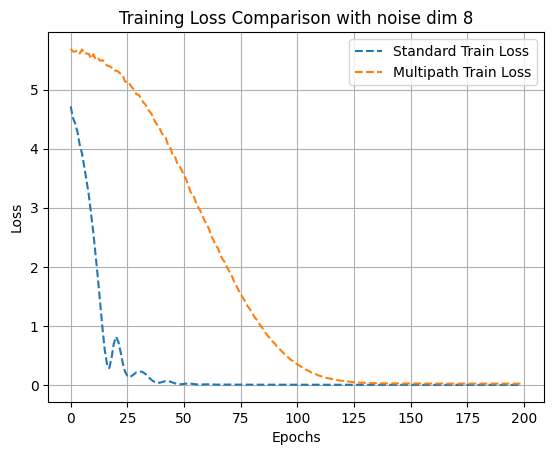

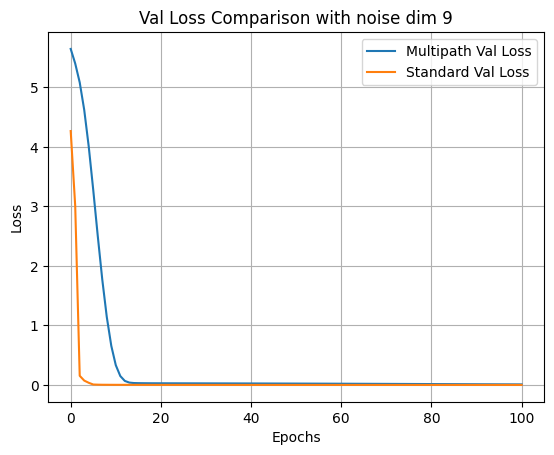

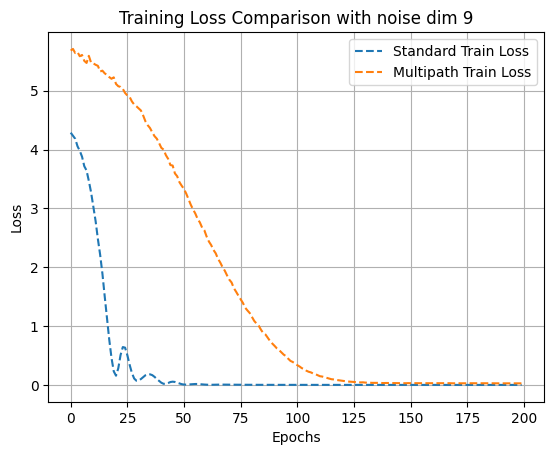

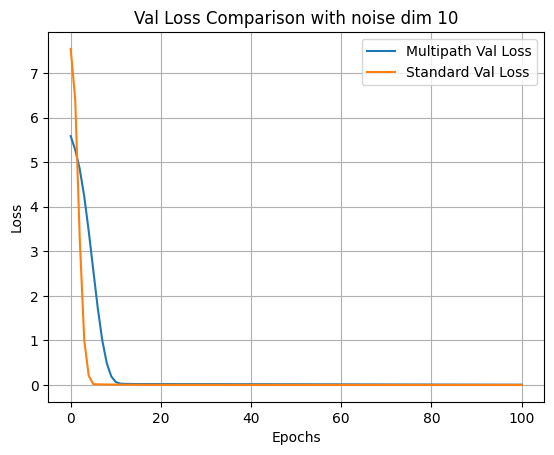

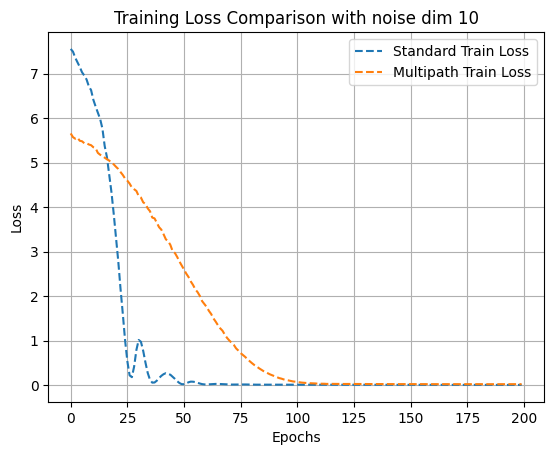

In [11]:

for noise_dim, (pmodel, smodel) in enumerate(models):
    # plt.plot(pmodel.training_loss, label='Multipath Train Loss')
    plt.plot(pmodel.validation_loss[:200], label='Multipath Val Loss')
    plt.plot(smodel.validation_loss[:200], label='Standard Val Loss')
    # add validation loss with dashed line

    plt.title(f'Val Loss Comparison with noise dim {noise_dim+2}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f'output/val_loss_comparison_{noise_dim+2}_eval_laguerre.png')
    plt.show()
    plt.clf()
    
    plt.plot(smodel.training_loss[:200], label='Standard Train Loss', linestyle='--')
    plt.plot(pmodel.training_loss[:200], label='Multipath Train Loss', linestyle='--')
    plt.title(f'Training Loss Comparison with noise dim {noise_dim+2}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig(f'output/train_loss_comparison_{noise_dim+2}_train_laguerre.png')
    plt.show()
    

In [9]:
# make now a table with the final losses
import pandas as pd
data = []
for noise_dim, (pmodel, smodel) in enumerate(models):
    data.append({
        'noise_dim': noise_dim+2,
        'Multipath Train Loss': pmodel.training_loss[-1],
        'Multipath Val Loss': pmodel.validation_loss[-1],
        'Standard Train Loss': smodel.training_loss[-1],
        'Standard Val Loss': smodel.validation_loss[-1],
        'Multipath Trainable Params': sum(p.numel() for p in pmodel.parameters() if p.requires_grad),
        'Standard Trainable Params': sum(p.numel() for p in smodel.parameters() if p.requires_grad),
    })
df = pd.DataFrame(data)
# save to csv
df.to_csv("training_results_laguerre.csv", index=False)
df

,noise_dim,Multipath Train Loss,Multipath Val Loss,Standard Train Loss,Standard Val Loss,Multipath Trainable Params,Standard Trainable Params
0,2,0.004508,0.060314,0.001343,0.057136,80,2945
1,3,0.003685,0.023585,0.001495,0.021335,150,3009
2,4,0.002977,0.008296,0.001396,0.006663,240,3073
3,5,0.003566,0.004190,0.001484,0.002086,350,3137
4,6,0.003790,0.003218,0.001523,0.001038,480,3201
5,7,0.004457,0.003739,0.001463,0.000888,630,3265
6,8,0.004365,0.003537,0.001438,0.000819,800,3329
7,9,0.012238,0.009464,0.001517,0.000571,990,3393
8,10,0.006923,0.005362,0.001566,0.000276,1200,3457


In [10]:
print(df.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
noise_dim & Multipath Train Loss & Multipath Val Loss & Standard Train Loss & Standard Val Loss & Multipath Trainable Params & Standard Trainable Params \\
\midrule
2 & 0.004508 & 0.060314 & 0.001343 & 0.057136 & 80 & 2945 \\
3 & 0.003685 & 0.023585 & 0.001495 & 0.021335 & 150 & 3009 \\
4 & 0.002977 & 0.008296 & 0.001396 & 0.006663 & 240 & 3073 \\
5 & 0.003566 & 0.004190 & 0.001484 & 0.002086 & 350 & 3137 \\
6 & 0.003790 & 0.003218 & 0.001523 & 0.001038 & 480 & 3201 \\
7 & 0.004457 & 0.003739 & 0.001463 & 0.000888 & 630 & 3265 \\
8 & 0.004365 & 0.003537 & 0.001438 & 0.000819 & 800 & 3329 \\
9 & 0.012238 & 0.009464 & 0.001517 & 0.000571 & 990 & 3393 \\
10 & 0.006923 & 0.005362 & 0.001566 & 0.000276 & 1200 & 3457 \\
\bottomrule
\end{tabular}



In [ ]:
train_x = torch.load('data/train_x.pt').to(torch.float32)
train_y = torch.load('data/train_y.pt').to(torch.float32)
test_x  =  torch.load('data/test_x.pt').to(torch.float32) #[:10,:]
test_y  =  torch.load('data/test_y.pt').to(torch.float32) #[:10]
validation_x = test_x[:len(test_x)//2,:]
validation_y = test_y[:len(test_y)//2]
test_x = test_x[len(test_x)//2:,:]
test_y = test_y[len(test_y)//2:]

generator = torch.Generator(device=device)

train_dataset = TensorDataset(train_x, train_y)
validation_dataset = TensorDataset(validation_x, validation_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)
validation_loader = DataLoader(validation_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=10024, shuffle=True, num_workers=0, generator=generator)

train_x.shape, train_y.shape, validation_x.shape, validation_y.shape, test_x.shape, test_y.shape,

(torch.Size([100000, 7]),
 torch.Size([100000]),
 torch.Size([5000, 7]),
 torch.Size([5000]),
 torch.Size([5000, 7]),
 torch.Size([5000]))

In [ ]:
noise_dim = 7 
path_model = MultiPath(train_x.shape[-1], 10, noise_dim=noise_dim)
trainer = Trainer(max_epochs=30, accelerator="auto", devices=1)
trainer.test(path_model, dataloaders=test_loader)
trainer.fit(path_model, train_dataloaders=train_loader, val_dataloaders=validation_loader)
trainer.test(path_model, dataloaders=test_loader)

ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
ic| input_dim: 7
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. 

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    6.3562421798706055     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | paths   | ModuleList | 630    | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
630       Trainable params
0         Non-trainable params
630       Total params
0.003     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:484: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorc

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.07174401730298996    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07174401730298996}]

300


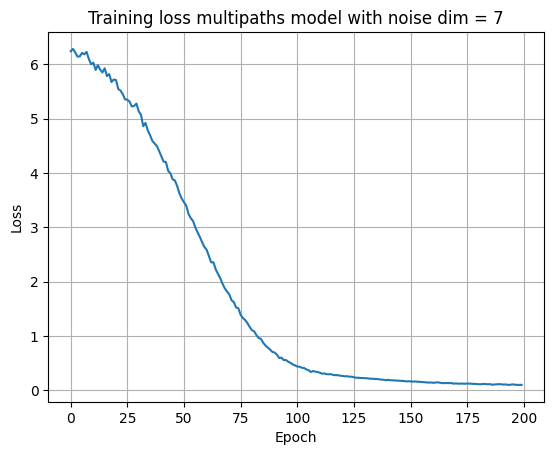

In [ ]:
print(len(path_model.training_loss))
plt.plot(torch.tensor(path_model.training_loss).cpu()[:200])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Training loss multipaths model with noise dim = " + str(noise_dim))
plt.grid()
plt.show()